In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from natsort import natsorted
from datetime import datetime

dB_AE_threshold = 80
V_rms_threshold = pow(10, dB_AE_threshold/20) * 100 * 10 ** -6

print(V_rms_threshold)


"""Define How to Get Waveform Metadata"""

dta_file_path_line_no = 1
dta_file_start_date_line_no = 2
dta_file_start_time_line_no = 3
sample_interval_line_no = 4
signal_units_line_no = 5
time_units_line_no = 6
data_points_per_waveform_line_no = 8
hit_time_line_no = 11
header_lines = 12

def extract_time_from_filename(filename):
    # Returns the time the csv was recorded in microseconds
    parts = filename.split('_')
    return int(parts[-1].strip('.csv'))

def get_waveform_metadata(wfm_directory):
    metadata = {}

    # Waveforms to read from the waveforms folder
    file_list = sorted([f for f in os.listdir(wfm_directory) if f.endswith('.csv')],
                    key=extract_time_from_filename)

    first_file_name = file_list[0]
    first_file_path = os.path.join(wfm_directory, first_file_name)

    # Extract the data after ":" in the string in the 1st column, 11th row
    with open(first_file_path, 'r') as file:
        lines = file.readlines()

        dta_file_start_time_line = lines[dta_file_start_time_line_no - 1].strip().split(':', 1)
        dta_file_start_time_str = dta_file_start_time_line[1].strip()
        dta_file_start_time = datetime.strptime(dta_file_start_time_str, "%H:%M:%S")
        metadata["dta_file_start_time"] = dta_file_start_time

        sample_interval_line = lines[sample_interval_line_no - 1].strip().split(':', 1)
        sample_interval = float(sample_interval_line[1].strip())
        AE_fs = 1 / sample_interval  # AE sampling frequency (Hz)
        metadata["AE_fs"] = AE_fs

        signal_units_line = lines[signal_units_line_no - 1].strip().split(':', 1)
        signal_units = signal_units_line[1].strip()
        metadata["signal_units"] = signal_units

        time_units_line = lines[time_units_line_no - 1].strip().split(':', 1)
        time_units = time_units_line[1].strip()
        metadata["time_units"] = time_units

        data_points_per_waveform_line = lines[data_points_per_waveform_line_no - 1].strip().split(':', 1)
        data_points_per_waveform = int(data_points_per_waveform_line[1].strip())
        metadata["data_points_per_waveform"] = data_points_per_waveform

    return metadata


"""Define How to Import and Plot Waveforms"""

def import_waveform_csv_to_df(filepath, metadata):
    # Use nrows=0 to read no data but still get the # of columns
    df = pd.read_csv(filepath, delimiter=',', header=12, nrows=0)
    num_columns = len(df.columns)

    # Read and return the dataframe for the CSV
    if num_columns == 1:
        # Only Voltage Column
        raw_df = pd.read_csv(filepath, delimiter=',', header=10, names=['Volts'])
        frequency = metadata['AE_fs']
        sampling_interval = 1/frequency

        # Create the 'Time' values based on the sampling interval and row index
        time_values = raw_df.index * sampling_interval

        # Insert the 'Time' column at the first position
        raw_df.insert(0, 'Time', time_values)
    else:
        # Time and Voltage Column
        raw_df = pd.read_csv(filepath, delimiter=',', header=10, names=['Time', 'Volts'])

    return raw_df

def plot_waveform(df, ax, title):
    ax.plot(df['Time'], df['Volts'], linewidth=1)
    # ax.axhline(y=V_rms_threshold, color='r', linestyle='--', label='V_rms threshold')
    # ax.axhline(y=-V_rms_threshold, color='r', linestyle='--', label='V_rms threshold')
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Voltage (V)')
    ax.grid(True)

def get_timestamp_from_filename(filename):
    return int(filename.split('_')[-1].split('.')[0])

def select_representative_files(folder_path, n):
    csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]
    csv_files = natsorted(csv_files, key=get_timestamp_from_filename)
    
    if n >= len(csv_files):
        return csv_files
    
    indices = np.linspace(0, len(csv_files) - 1, n, dtype=int)
    return [csv_files[i] for i in indices]

def plot_multiple_waveforms(folder_path, n):
    metadata = get_waveform_metadata(folder_path)
    
    files = select_representative_files(folder_path, n)
    
    fig, axes = plt.subplots(n, 1, figsize=(12, 4*n), sharex=True)
    if n == 1:
        axes = [axes]
    
    for ax, file in zip(axes, files):
        filepath = os.path.join(folder_path, file)
        df = import_waveform_csv_to_df(filepath, metadata)
        plot_waveform(df, ax, f"Waveform: {file}")
    plt.xlim(0, 0.001)
    plt.tight_layout()
    plt.show()

1.0


In [53]:
"""Get Waveform Folder From User"""

# Get the Mistras AE Waveforms filepath from the user
mistras_wfm_dir_root = ''
while mistras_wfm_dir_root == '':
    mistras_wfm_dir_root = input("Enter the directory of the Mistras AE waveforms: ")
    if os.path.isdir(mistras_wfm_dir_root):
        print(f"'{mistras_wfm_dir_root} is a valid directory. Continuing...")
        break
    else:
        print(f"'{mistras_wfm_dir_root} is not a valid directory. Try Again:")
        mistras_wfm_dir_root = ''

'C:\Users\sapierso\Documents\AE Data\AENode_PreampOne5V_R3a_plugged_in_wfms is a valid directory. Continuing...


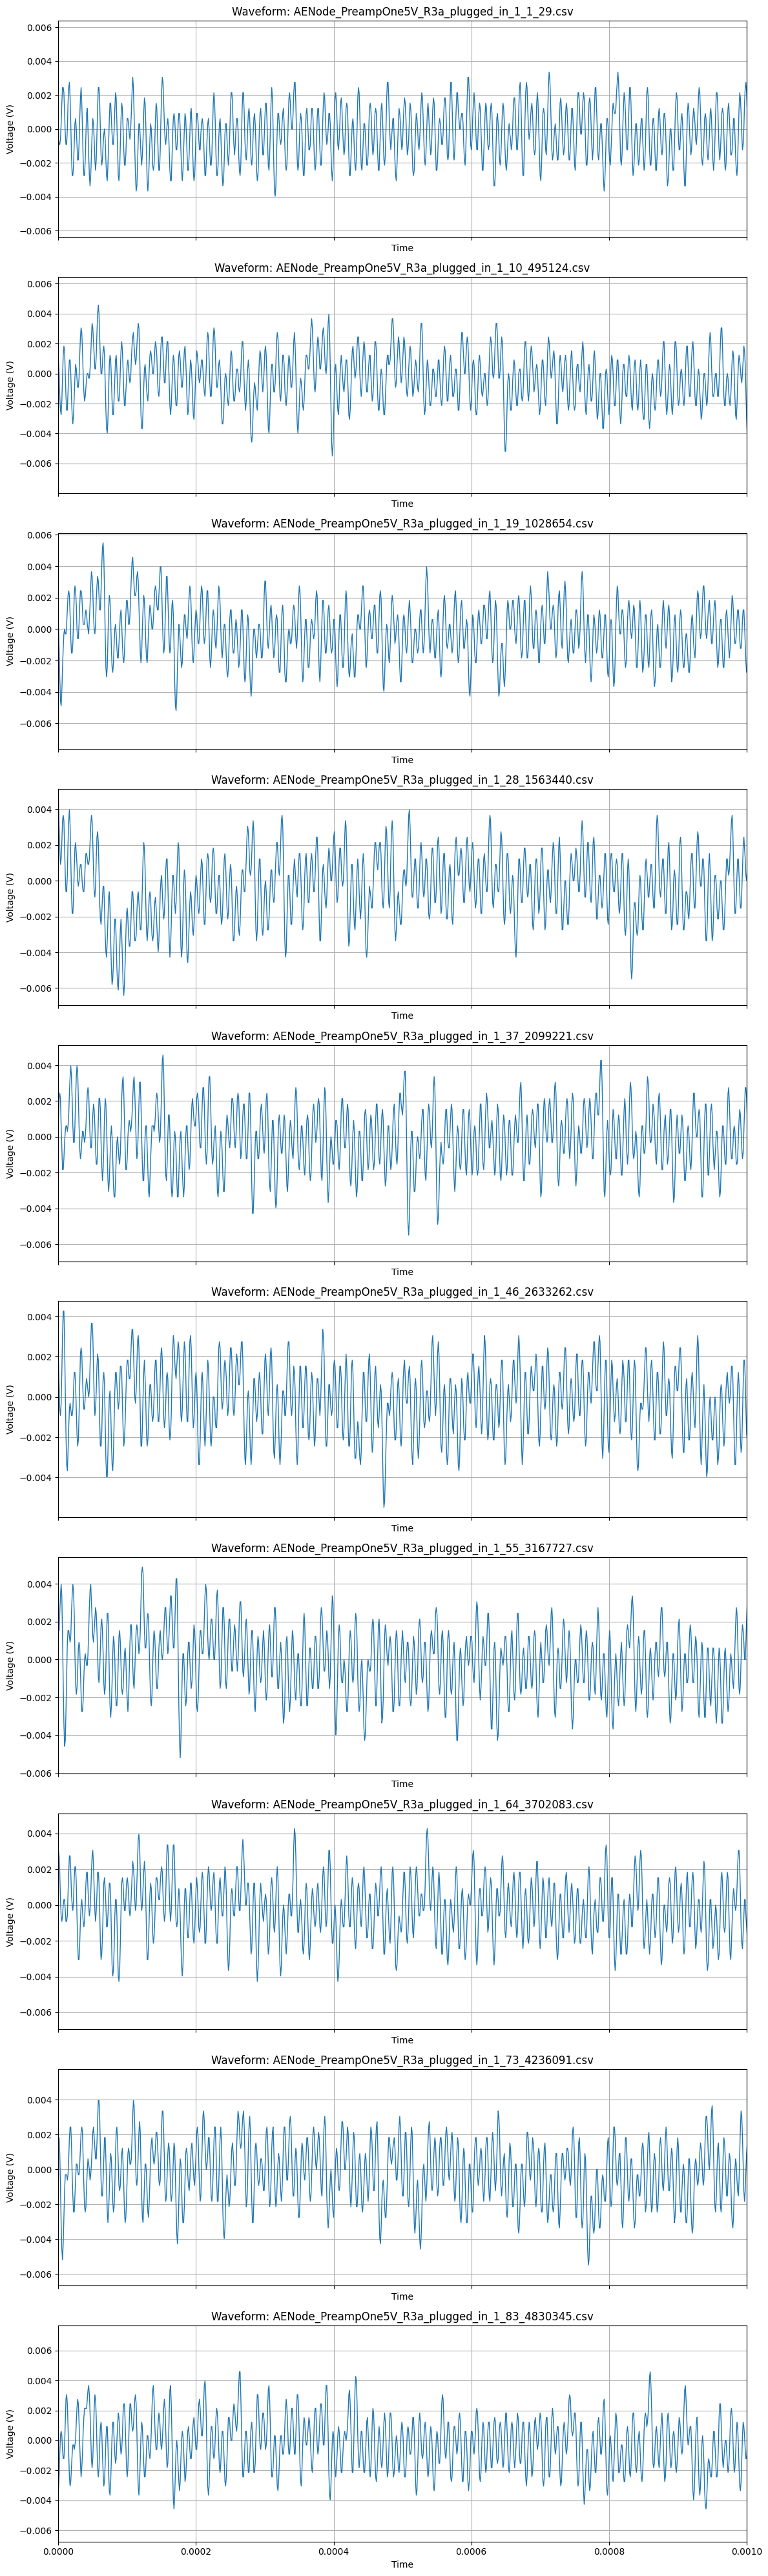

In [54]:
n = int(input("Enter the number of waveforms to plot: "))

plot_multiple_waveforms(mistras_wfm_dir_root, n)